In [1]:
# A) Stability analysis of the semi-discretized complete TFM

# Questions:
# Physical interpretation of eigenvalues

# To do:
# Discretize with SUPG, DG
# Check for DG

In [1]:
# 1/6
"""
Two-fluid model
"""

# Libraries
from fenics import *
from dolfin import *
from mshr import *
from IPython.display import clear_output
from scipy.optimize import brenth
from scipy.optimize import fsolve
from scipy.linalg import eig
from scipy.sparse.linalg import eigs
from scipy.interpolate import interp1d
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from matplotlib import rc
from math import pi
from scipy.sparse import csr_matrix
from numpy import linalg as LA
from scipy import sparse

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal
import time
import math
import ufl      
%matplotlib inline

# Phase properties
c2               = 293.43                 # Sanderse 2017
u4eq             = 1e5                    # Pa, outlet pressure (equilibrium state)
rho1             = 1000                   # kg m^-3, liquid density (Montini)
mu1              = 8.9e-4                 # Pa s, liquid viscosity
mu2              = 1.8e-5                 # Pa s, gas viscosity
sigma            = 0.072                  # Montini 2011

# Driving force
force            = 74.225 #Hendrix

# Gravity
g                = 9.8 # m/s^2

# Configuration
d                = 0.078                  # m, diameter
L                = 1                      # m, pipe length
beta_deg         = 0                     
beta             = pi*beta_deg/180
Area             = pi*pow (abs (d), 2.)/4. # mˆ2, total area
S                = pi*d
roughness        = 1e-8                   # m, pipe roughness

# superficial velocities (check well-posedness [as a function])
# for j1, j2 in [(0.05, 0.829), (0.5, 6.908)]:
#     print('>>> j1 = ', j1)
#     print('>>> j2 = ', j2)
    
j1         = 0.05                # 0.05  # 0.5      liquid superficial velocity
j2         = 0.829              # 0.829 # 6.908    gas superficial velocity

# j1         = 0.5                # 0.05  # 0.5      liquid superficial velocity
# j2         = 6.908              # 0.829 # 6.908    gas superficial velocity


# artifical diffusion coefficients (depend on superficial velocities and stability analysis)
E11        = 0               #0.001 
E22        = 0               #0.01

# FUNCTIONS
# stratification angle
def gamma (u1):
    return 2*(pi*(1. - u1) + pow ((3.*pi/2.)+ DOLFIN_EPS, (1./3.))*(2.*u1 - 1. + pow (abs (1. - u1)+ DOLFIN_EPS, (1./3.))- pow (abs(u1)+ DOLFIN_EPS, (1/3))))

# 2*(pi*(1. - u1) + pow (abs(3.*pi/2.), (1./3.))*(2.*u1 - 1. + pow (abs (1. - u1), (1./3.))- pow (abs(u1), (1/3))) - (1./200.)*u1*(1. - u1)*(2.*u1 - 1.)*(1. + 4.*(pow (abs (u1), 2.) + pow (abs(1.- u1), 2.))))
# 2*(pi*(1 - (u1)) + pow (((3*pi + DOLFIN_EPS)/2), 1/3)*(1 - 2*(1 - (u1)) + pow ((1 - u1) + DOLFIN_EPS, 1/3) - pow (u1 + DOLFIN_EPS, 1/3)))

# liquid holdup
def alpha1 (u1):
    return 1 - u1

# liquid phase velocity
def u3 (u1):
    return j1/(1. - u1)
# liquid phase velocity
def u3b (j1):
    return j1/(1. - u1)
# gas phase velocity
def u2 (u1):
    return j2/u1

# liquid sectional area
def A1 (gamma):
    return (d**2)/4*(gamma/2 - np.sin (gamma/2)*np.cos (gamma/2))
# gas sectional area
def A2 (gamma):
    return (d**2)/4*(pi - gamma/2 + np.sin (gamma/2)*np.cos (gamma/2))
# liquid wetted perimeter
def S1 (gamma):
    return d*gamma/2.
# gas wetted perimeter
def S2 (gamma):
    return d/2.*(2.*pi - gamma)
# interface wetted perimeter
def Si (gamma):
    return d*np.sin (gamma/2)

# liquid hydraulic diameter 
def dh1 (A1, S1):
    return 4.*A1/S1
# gas hydraulic diameter 
def dh2 (A2, S2, Si):
    return 4.*A2/(S2 + Si)
# critic diameter
def Dc (gamma):
    return g*np.cos (beta)*pi*d/(4*np.sin (gamma/2))

# liquid Reynolds number
def Re1 (u3, dh1):
    return rho1*u3*dh1/mu1
# gas Reynolds number
def Re2 (u2, dh2):
    return u4eq/pow ((c2), 2)*u2*dh2/mu2

# liquid shear stress
def tauw1 (f1, u3):
    return f1*rho1*u3*abs (u3)/2.
# gas shear stress
def tauw2 (f2, u2):
    return f2*u4eq/pow (c2, 2)*u2*abs (u2)/2.
# interface shear stress
def tau21 (fi, u3, u2):
    return fi*u4eq/pow (c2, 2)*(u2 - u3)*abs (u2 - u3)/2.
# interface shear stress
def tau12 (fi, u3, u2):
    return fi*u4eq/pow (c2, 2)*(u3 - u2)*abs (u3 - u2)/2.

# liquid friction factor 1
def f1 (Re1, dh1):
    Af1 = pow (2.457*np.log(pow(pow(abs(7/Re1), 0.9) + 0.27*roughness/dh1, - 1)), 16)
    Bf1 = pow (abs (37530/Re1), 16)
    return 2*pow (pow (abs (8/Re1), 12)+pow (abs (Af1 + Bf1), - 1.5), 1/12)

# gas friction factor 2
def f2 (Re2, dh2):
    Af2 = pow (2.457*np.log(pow(pow(abs(7/Re2), 0.9) + 0.27*roughness/dh2, - 1)), 16)
    Bf2 = pow (abs (37530/Re2), 16)
    return 2*pow (pow (abs (8/Re2), 12)+pow (abs (Af2 + Bf2), - 1.5), 1/12)

# interfacial friction
def fi (f2):
    return max (f2, 0.014)

# steady state momentum equation
def equilibrium1 (u1): 
    func = - (rho1 - u4eq/pow (c2, 2))*g*np.sin (beta) - tauw1 (f1 (Re1 (u3 (u1), dh1 (A1 (gamma (u1)), S1 (gamma (u1)))), dh1 (A1 (gamma (u1)), S1 (gamma (u1)))), u3 (u1))*S1 (gamma (u1))/A1 (gamma(u1)) + tauw2 (f2 (Re2 (u2 (u1), dh2 (A2 (gamma (u1)), S2 (gamma (u1)), Si (gamma (u1)))), dh2 (A2 (gamma (u1)), S2 (gamma (u1)), Si (gamma (u1)))), u2 (u1))*S2 (gamma (u1))/A2(gamma (u1)) + tau21 (fi (f2 (Re2 (u2 (u1), dh2 (A2 (gamma (u1)), S2 (gamma (u1)), Si(gamma (u1)))), dh2 (A2 (gamma (u1)), S2 (gamma (u1)), Si (gamma (u1))))), u3 (u1), u2 (u1))*Si(gamma (u1))*((1/A1 (gamma (u1))) + (1/A2 (gamma (u1))))
    return func

# Void fraction equilibrium
lima    = 1e-15
limb    = 1 - lima
u1eq    = brenth (equilibrium1, lima, limb)

# messages for void fraction and Reynolds
print ("Void fraction = ", u1eq)
print (" ")
print ("Reynolds 1    = ", Re1 (u3 (alpha1 (u1eq)), dh1 (A1 (gamma (u1eq)), S1 (gamma (u1eq)))))
print ("Reynolds 2    = ", Re2 (u2 (alpha1 (u1eq)), dh2 (A2 (gamma (u1eq)), S2 (gamma (u1eq)), Si (gamma (u1eq)))))
print (" ")

# parameters used in boundary conditions
u1_0     = u1eq
u2_0     = u2 (u1eq)
u3_0     = u3 (u1eq)
u4_0     = u4eq

# messages for boundary conditions just at the entrance, but not the actual base flow)
print ("Boundary conditions phi (t, x)")
print ("Gas void fraction    : u1_0 (t, 0) = ", u1_0, "[-]")
print ("Gas velocity         : u2_0 (t, 0) = ", u2_0, "[m/s]")
print ("Liquid velocity      : u3_0 (t, 0) = ", u3_0, "[m/s]")
print ("Interfacial pressure : u4_0 (t, L) = ", u4_0, "Pa")

print (" ")

print ("Liquid holdup    = ", 1 - u1_0, "[-]")
print ("Liquid velocity  = ", u3_0, "[m/s]")


Void fraction =  0.4998877646488482
 
Reynolds 1    =  8766.991358653058
Reynolds 2    =  5096.651799707477
 
Boundary conditions phi (t, x)
Gas void fraction    : u1_0 (t, 0) =  0.4998877646488482 [-]
Gas velocity         : u2_0 (t, 0) =  1.6583722559849816 [m/s]
Liquid velocity      : u3_0 (t, 0) =  0.09997755796734847 [m/s]
Interfacial pressure : u4_0 (t, L) =  100000.0 Pa
 
Liquid holdup    =  0.5001122353511518 [-]
Liquid velocity  =  0.09997755796734847 [m/s]


In [2]:
# 2/6
# Choose linear algebra backend    
parameters["linear_algebra_backend"] = "PETSc"

# Allow approximating values for points that may be generated outside
# of domain (because of numerical inaccuracies)
parameters["allow_extrapolation"] = True
parameters["refinement_algorithm"] = "plaza_with_parent_facets"

# Conditional
# ufl.algorithms.apply_derivatives.CONDITIONAL_WORKAROUND = True  

# Form compiler options
parameters ["form_compiler"]["optimize"]          = True
parameters ["form_compiler"]["cpp_optimize"]      = True
# parameters ["form_compiler"]["quadrature_degree"] = 2

ffc_options = {"optimize":                          True, \
               "eliminate_zeros":                   True, \
               "precompute_basis_const":            True, \
               "precompute_ip_const":               True}

# Define constants
var1bc1   = u1_0                    # alpha2
var2bc1   = u2_0                    # u2
var3bc1   = u3_0                    # u1
var4bc1   = u4_0                    # p

# Define space discretization properties
xmin      = 0
xmax      = L
nx        = 40                             # no. of elements 100 to 1600 -------200
p         = 1                              # interpolation degree
mesh      = IntervalMesh (nx, xmin, xmax)
h         = CellDiameter (mesh)
deltax    = d/2.                           # D/2 Bonzanini #0.256*D holmas

# Save mesh
File ("slugging/mesh.xml") << mesh

# Sub domain for Periodic boundary condition
class PeriodicBoundary(SubDomain):

    # Left boundary is "target domain" G
    def inside(self, x, on_boundary):
        return bool(x[0] < DOLFIN_EPS and x[0] > -DOLFIN_EPS and on_boundary)

    # Map right boundary (H) to left boundary (G)
    def map(self, x, y):
        y[0] = x[0] - 1.0
        

# Define funcion spaces
V1                     = FiniteElement ('Lagrange', mesh.ufl_cell(), degree = p)
V2                     = FiniteElement ('Lagrange', mesh.ufl_cell(), degree = p+1)
V3                     = FiniteElement ('Lagrange', mesh.ufl_cell(), degree = p+1)
V4                     = FiniteElement ('Lagrange', mesh.ufl_cell(), degree = p)
element                = MixedElement ([V1, V2, V3, V4])
V                      = FunctionSpace (mesh, element, constrained_domain = PeriodicBoundary())

# Define test and trial functions
v1, v2, v3, v4         = TestFunctions (V)

var                    = Function (V, name = "Variables at current step")
var1, var2, var3, var4 = split (var)

dvar                   = TrialFunction (V)

# Define boundary condition
var1_bc = Expression ("var1bc1", degree = p, var1bc1 = var1bc1) #var1bc1
var2_bc = Expression ("var2bc1", degree = p, var2bc1 = var2bc1) #var2bc1
var3_bc = Expression ("var3bc1", degree = p, var3bc1 = var3bc1) #var3bc1
var4_bc = Expression ("var4bc1", degree = p, var4bc1 = var4bc1) #var4bc1

# Sub domain for Dirichlet boundary condition
def right(x, on_boundary): return x[0] > (1.0 - DOLFIN_EPS)

def left(x, on_boundary): return x[0] < DOLFIN_EPS

bc1     = DirichletBC(V.sub (0), var1_bc, left, "pointwise")
bc2     = DirichletBC(V.sub (1), var2_bc, left, "pointwise")
bc3     = DirichletBC(V.sub (2), var3_bc, left, "pointwise")
bc4     = DirichletBC(V.sub (3), var4_bc, right, "pointwise")
bcs     = [bc1, bc2, bc3, bc4]

# Define expressions used in weak form
# k       = Expression ("dt", degree = p, dt = dt)
# E11     = Expression ("E11", degree = p, E11 = E11)
# E22     = Expression ("E22", degree = p, E22 = E22)

# Define files
ff1 = File ("slugging/var1.pvd", "compressed")
ff2 = File ("slugging/var2.pvd", "compressed")
ff3 = File ("slugging/var3.pvd", "compressed")
ff4 = File ("slugging/var4.pvd", "compressed")

Calling FFC just-in-time (JIT) compiler, this may take some time.


In [3]:
# 3/6
# Define expressions and constants used in weak form
# rho1      = Constant (rho1)
# c2        = Constant (c2)

# Area      = Constant (Area)
# d         = Constant (d)
# beta      = Constant (beta)
# roughness = Constant (roughness)

# force     = Constant (force)
# g         = Constant (g)

beta1     = Expression ("beta*x[0]", degree = p, beta = beta)              

# For UFL
def Max (a, b): 
    return (a + b + abs (a - b))/2

def Min (a, b): 
    return (a + b - abs (a - b))/2

def gamma (var1):
    term0 = (2*(pi*(1 - (var1)) + pow (((3*pi )/2), 1/3)*(1 - 2*(1 - (var1)) + pow ((1 - var1), 1/3) - pow (var1 + DOLFIN_EPS, 1/3))))
    return term0

# Functions used in weak form
def conv_mass2 (var1, var2, var4):
    term1  = var1*var4*var2/pow(abs(c2),2)
    return term1

# Functions used in weak form
def conv_mass1 (var1, var3):
    term2  = (1 - var1)*rho1*var3
    return term2

def conv_mom2 (var1, var2, var4):
    term3  = var1*var4*pow (var2, 2)/pow (abs (c2),2)
    return term3

def conv_mom1 (var1, var3):
    term4  = (1 - var1)*rho1*pow (abs (var3),2)
    return term4

def Dc1 (var1):
    term5  = rho1*(1 - var1)*g*cos (beta1)*pi*d/(4*sin (gamma (var1)/2))
    return term5
    
def Dc2 (var1, var4):
    term6  = var4*var1*g*cos (beta1)*pi*d/(4*sin (gamma (var1)/2)*pow (c2,2))
    return term6

def F1 (var1, var3):
    S1    = d*gamma (var1)/2
    
    dh1   = (4*(1 - var1)*Area/S1)
    f1    = 0.046*pow(abs(abs(var3)*dh1*rho1/mu1)+DOLFIN_EPS,-0.2)
    tau1  = f1*rho1*var3*abs (var3)/2.
    term7  = S1*tau1/Area
    return term7

def F2 (var1, var2, var4):
    S2    = d/2*(2*pi - gamma (var1))
    S21   = d*sin (gamma (var1)/2)
    
    dh2   = (4*(1 - var1)*Area/(S2+S21))
    f2    = 0.046*pow(abs(abs(var2)*dh2*var4/pow(c2,2))+DOLFIN_EPS, - 0.2)
    tau2  = f2*var4/pow(c2,2)*var2*abs (var2)/2.
    term8 = S2*tau2/Area
    return term8

def F21 (var1, var2, var3, var4):
    S2    = d/2*(2*pi - gamma (var1))
    S21   = d*sin (gamma (var1)/2)
    
    dh2   = (4*(1 - var1)*Area/(S2+S21))
    f2    = 0.046*pow(abs(abs(var2)*dh2*var4/pow(c2,2))+DOLFIN_EPS, - 0.2)
    
    f21    = Max (f2, 0.014)
    tau21  = f21*var4*(var2 - var3)*abs (var2 - var3)/(2.*pow(abs(c2),2))
    term9  = S21*tau21/Area
    return term9

def F12 (var1, var2, var3, var4):
    S2    = d/2*(2*pi - gamma (var1))
    S12   = d*sin (gamma (var1)/2)
    
    dh2   = (4*(1 - var1)*Area/(S2+S12))
    f2    = 0.046*pow(abs(abs(var2)*dh2*var4/pow(c2,2))+DOLFIN_EPS, - 0.2)
    
    f12    = Max (f2, 0.014)
    tau12  = f12*var4*(var3 - var2)*abs (var3 - var2)/(2.*pow(abs(c2),2))
    term10  = S12*tau12/Area
    return term10

In [4]:
# # Define functions used in weak form

# mass2 = ( - Dx (conv_mass2 (var1, var2, var3, var4),0)*v1 + \
#          1*(inner (var4*E11/pow(c2,2)*grad (var1), grad (v1))) )*dx

# mass1 = ( - Dx (conv_mass1 (var1, var2, var3, var4),0)*v2 - \
#          1*(inner (rho1*E11*grad (1-var1), grad (v1))) )*dx

# mom2  = ( - Dx (conv_mom2 (var1, var2, var3, var4),0)*v3 - (var1)*Dx (var4,0)*v3 + \
#          Dc2 (var1, var2, var3, var4)*Dx (var1,0)*v3   - F2 (var1,var2,var3,var4)*v3 - \
#          F21 (var1,var2,var3,var4)*v3 - var4*var1*g*sin (beta1)/pow (abs (c2),2)*v3 - \
#          force*v3 + 1*(inner (var1*E22*grad (var2), grad (v3))) )*dx

# mom1  = ( - Dx (conv_mom1 (var1, var2, var3, var4),0)*v4 - (1 - var1)*Dx (var4,0)*v4 - \
#          Dc1 (var1, var2, var3, var4)*Dx (1-var1,0)*v4 - F1 (var1,var2,var3,var4)*v4 - \
#          F12 (var1,var2,var3,var4)*v4 - rho1*(1 - var1)*g*sin (beta1)*v4 - force*v4 -\
#          1*(inner ((1-var1)*E22*grad (var3), grad (v4))))*dx


>>> diffusion coeff continuity =  0
>>> diffusion coeff momentum   =  0
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Condition number : inf
Is symmetric : False
Is positive definite : False
Recommended BiCGStab and GMRES. BiCGStab may break down: GMRES has a parameter -the number of search vectors- that may be tuned.
max eigenvalue real =  [0.99691733]


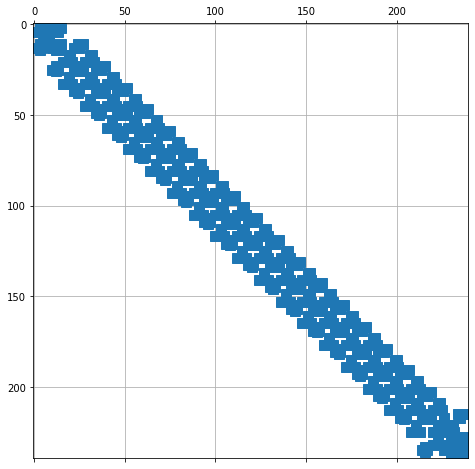

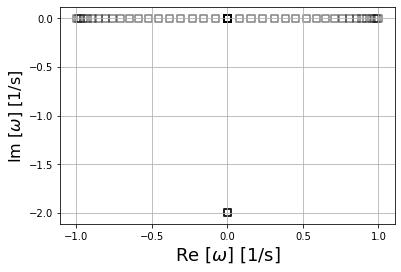

In [5]:
# 4/6

print('>>> diffusion coeff continuity = ',E11)
print('>>> diffusion coeff momentum   = ',E22)

# Define functions used in weak form
mass2 = ( - Dx (conv_mass2 (var1, var2, var4),0)*v1\
             + (inner (var4*E11/pow(c2,2)*grad (var1), grad (v1))) )*dx

mass1 = ( - Dx (conv_mass1 (var1, var3),0)*v2\
             + (inner (rho1*E11*grad (1-var1), grad (v1))) )*dx

mom2  = ( - Dx (conv_mom2 (var1, var2, var4),0)*v3\
             - 1*(var1)*Dx (var4,0)*v3\
             + 1*Dc2 (var1, var4)*Dx (var1,0)*v3\
             - 0*F2 (var1,var2,var4)*v3\
             - 0*F21 (var1,var2,var3,var4)*v3\
             - 1*var4*var1*g*sin (beta1)/pow (abs (c2),2)*v3\
             - 0*force*v3 \
             + (inner (var1*E22*grad (var2), grad (v3))) )*dx

mom1  = ( - Dx (conv_mom1 (var1, var3),0)*v4\
             - 1*(1 - var1)*Dx (var4,0)*v4\
             + 1*Dc1 (var1)*Dx (1-var1,0)*v4\
             - 0*F1 (var1,var3)*v4\
             + 0*F21 (var1,var2,var3,var4)*v4\
             - 1*rho1*(1 - var1)*g*sin (beta1)*v4\
             + 0*force*v4\
             + (inner ((1-var1)*E22*grad (var3), grad (v4))))*dx

# Define weak form (semi distretised without artificial difussion)
F  = mass2 + mass1 + mom2 + mom1

# Auxiliary
L  = Constant (0)*v1*dx + Constant (0)*v2*dx + Constant (0)*v3*dx + Constant (0)*v4*dx

# Define Jacobian
dF = derivative (F, var, dvar)

    # #########
    # # 1st alternative to assembling
    # A, b = assemble_system (dF, L, bcs)

    # A_mat = as_backend_type (A).mat ()

    # # Transform to numpy array
    # A_sparray = csr_matrix(A_mat.getValuesCSR()[::-1], shape = A_mat.size)

    # # Print array
    # # print("A_sparray             =", A_sparray)

    # # Plot array
    # plt.figure (3, figsize = (12, 8))
    # plt.spy(A_sparray)
    # plt.grid (True, which = "both")
    # # plt.rcParams ['figure.figsize'] = [12, 8]

    # plt.show

    # Aeval           = A_sparray.toarray ()

    # Acomplex        = Aeval.dot (1j)

    # condnumber = LA.cond(Aeval)
    # print("Condition number :", condnumber)

    ########
    # 2nd alternative to assembling
    # Assemble stiffness form    
A  = PETScMatrix()
b  = PETScVector()

assemble_system(dF, L, bcs, A_tensor = A, b_tensor = b)

A_mat = as_backend_type(A).mat()

    # Transform to numpy array
A_sparray = csr_matrix(A_mat.getValuesCSR()[::-1], shape = A_mat.size)

    # Print array
    # print("A_sparray             =", A_sparray)

    # Plot array
plt.figure (3, figsize = (12, 8))
plt.spy(A_sparray)
plt.grid (True, which = "both")
    # plt.rcParams ['figure.figsize'] = [12, 8]

plt.show

Acomplex_sparse = A_sparray.dot (1j)

Aeval           = A_sparray.toarray ()
Acomplex        = Aeval.dot (1j)

print("Condition number :", LA.cond(Aeval))

print('Is symmetric :', np.linalg.norm(A.array() - A.array().T) < 1E-10)

temp=A.mat()
#     print('Is symmetric :', temp.isSymmetric(1E-10))

import numpy as np

def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

print('Is positive definite :', is_pos_def(Aeval))

print('Recommended BiCGStab and GMRES. BiCGStab may break down: GMRES has a parameter -the number of search vectors- that may be tuned.')

vals, vecs = eig ( - Acomplex, overwrite_a = True) #alternative1

    # eigensolver = SLEPcEigenSolver (A)
    # print("Computing eigenvalues. This can take a minute.")
    # eigensolver.solve ()

    # # Extract largest (first) eigenpair
    # r, c, rx, cx = eigensolver.get_eigenpair(0)

    # vals, vecs = eigs ( - Acomplex_sparse) #tol = 1e-10

    # Eigenvalues
imagvals = vals.imag
realvals = vals.real

    # print("realvals = ", vals.real)
    # print("imagvals = ", vals.imag)

    # Eigenvectors
imagvecs = vecs.imag
realvecs = vecs.real

    # print("realvecs = ", vecs.real)
    # print("imagvecs = ", vecs.imag)

    # Largest eigenvalues and eigenvectors localization
localmaxreal = np.where(vals.real == vals.real.max())
localmaximag = np.where(vals.imag == vals.imag.max())

    # Largest eigenvalues and eigenvectors localization
localminreal = np.where(vals.real == vals.real.min())
localminimag = np.where(vals.imag == vals.imag.min())

    # print("localmaxreal =", localmaxreal)
    # print("localmaximag =", localmaximag)

    # print("localminreal =", localminreal)
    # print("localminimag =", localminimag)

    # print("min eigenvalue real = ", vals.real[localminreal[0]])
print("max eigenvalue real = ", vals.real[localmaxreal[0]])

eigenvector_real = vecs.real[localmaxreal[0]]
eigenvector_imag = vecs.imag[localmaximag[0]]

#     print("eigenvector_real =", eigenvector_real[0])
#     print("eigenvector_imag =", eigenvector_imag[0])

    # Characteristics for plots
liststyles       = ["--", "-", "-.", "."]
listcolor        = ["k", "g", "b", "r", "none"]
listmarkers      = ["s", "o", "^", ">", "<", "p"]

    # Plot eigenspectra 1
fig, ax = plt.subplots ()
area = 50

ax.scatter (realvals, imagvals, s = area, marker = listmarkers [0], color = listcolor [4], edgecolors = listcolor [0], linewidths = 1.5, alpha = 0.5)
# ax.set_xscale ('symlog', linthreshx = 1e-4)

plt.rcParams ['figure.figsize'] = [12, 8]
    # leg1 = ax.legend (loc = 'upper right', frameon = True, fontsize = 14);
plt.grid (True, which = "both")
plt.xlabel ('Re $[\omega]$ [1/s]', fontsize = 18)
plt.ylabel ('Im $[\omega]$ [1/s]', fontsize = 16)

matplotlib.rc ('xtick', labelsize = 18)     
matplotlib.rc ('ytick', labelsize = 18)

    # plt.ylim (( - 0.002 , ))
    # plt.xlim (( 2*vals.real[localminreal[0]], 2*vals.real[localmaxreal[0]]))
plt.show ()    

    # Eigenvectors
    # Plot real eigenvectors
# ureal  = Function(V)
# ureal.vector()[:] = eigenvector_real[0] #len(vecs)-1 
# u1real, u2real, u3real, u4real= ureal.split()

#     # Plot eigenfunction
# plt.figure (3, figsize = (12, 8))
# plot(u1real, wireframe = True, title = 'Eigenfunction')
# plt.grid (True, which = "both")
# plt.xlabel("L")
# plt.ylabel("rx (Eigenvector of the largest real eigenvalue)")

# # Plot eigenfunction
# plt.figure (3, figsize = (12, 8))
# plot(u2real, wireframe = True, title = 'Eigenfunction')
# plt.grid (True, which = "both")
# plt.xlabel("L")
# plt.ylabel("rx (Eigenvector of the largest real eigenvalue)")

#     # Plot eigenfunction
# plt.figure (3, figsize = (12, 8))
# plot(u3real, wireframe = True, title = 'Eigenfunction')
# plt.grid (True, which = "both")
# plt.xlabel("L")
# plt.ylabel("rx (Eigenvector of the largest real eigenvalue)")

#     # Plot eigenfunction
# plt.figure (3, figsize = (12, 8))
# plot(u4real, wireframe = True, title = 'Eigenfunction')
# plt.grid (True, which = "both")
# plt.xlabel("L")
# plt.ylabel("rx (Eigenvector of the largest real eigenvalue)")

    # # Plot imaginary eigenvectors
    # uimag = Function(V)
    # uimag.vector()[:] = eigenvector_imag[0] #eigenfunction)
    # u1imag, u2imag, u3imag, u4imag = uimag.split()
    # 
    # # Plot eigenfunction
    # plt.figure (4, figsize = (12, 8))
    # plot(u1imag, wireframe = True, title = 'Eigenfunction')
    # plt.grid (True, which = "both")
    # plt.xlabel("L")
    # plt.ylabel("cx (Eigenvector of the largest imaginary eigenvalue)")

    # plt.figure (4, figsize = (12, 8))
    # plot(u2imag, wireframe = True, title = 'Eigenfunction')
    # plt.grid (True, which = "both")
    # plt.xlabel("L")
    # plt.ylabel("cx (Eigenvector of the largest imaginary eigenvalue)")

    # plt.figure (4, figsize = (12, 8))
    # plot(u3imag, wireframe = True, title = 'Eigenfunction')
    # plt.grid (True, which = "both")
    # plt.xlabel("L")
    # plt.ylabel("cx (Eigenvector of the largest imaginary eigenvalue)")

    # plt.figure (4, figsize = (12, 8))
    # plot(u4imag, wireframe = True, title = 'Eigenfunction')
    # plt.grid (True, which = "both")
    # plt.xlabel("L")
    # plt.ylabel("cx (Eigenvector of the largest imaginary eigenvalue)")

# plt.show()

#     # SAVE LARGEST REAL
# File("slugging/eigenmodesu1_real.pvd") << u1real
# File("slugging/eigenmodesu2_real.pvd") << u2real
# File("slugging/eigenmodesu3_real.pvd") << u3real
# File("slugging/eigenmodesu4_real.pvd") << u4real

    # # SAVE LARGEST IMAGINARY
    # File("slugging/eigenmodesu1_imag.pvd") << u1imag
    # File("slugging/eigenmodesu2_imag.pvd") << u2imag
    # File("slugging/eigenmodesu3_imag.pvd") << u3imag
    # File("slugging/eigenmodesu4_imag.pvd") << u4imag

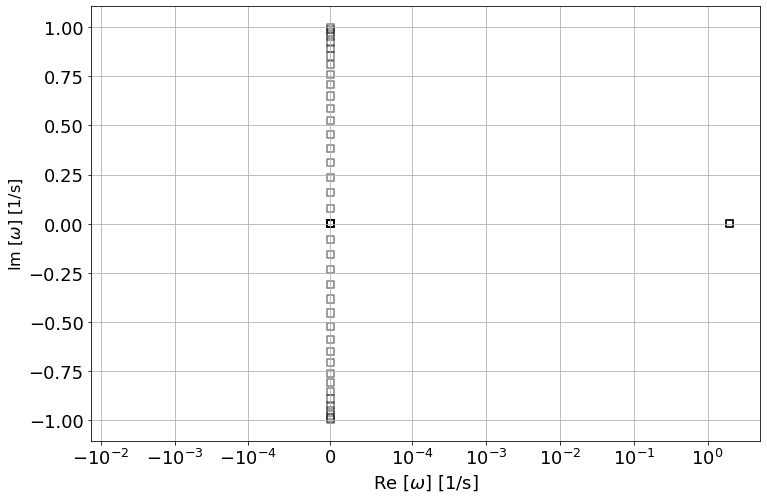

In [6]:
vals, vecs = eig ( Aeval, overwrite_a = True) #alternative1

# eigensolver = SLEPcEigenSolver (A)
# print("Computing eigenvalues. This can take a minute.")
# eigensolver.solve ()

# # Extract largest (first) eigenpair
# r, c, rx, cx = eigensolver.get_eigenpair(0)

# vals, vecs = eigs ( - Acomplex_sparse) #tol = 1e-10

# Eigenvalues
imagvals = vals.imag
realvals = vals.real

# print("realvals = ", vals.real)
# print("imagvals = ", vals.imag)

# Eigenvectors
imagvecs = vecs.imag
realvecs = vecs.real

# print("realvecs = ", vecs.real)
# print("imagvecs = ", vecs.imag)

# Largest eigenvalues and eigenvectors localization
localmaxreal = np.where(vals.real == vals.real.max())
localmaximag = np.where(vals.imag == vals.imag.max())

# Largest eigenvalues and eigenvectors localization
localminreal = np.where(vals.real == vals.real.min())
localminimag = np.where(vals.imag == vals.imag.min())

# print("localmaxreal =", localmaxreal)
# print("localmaximag =", localmaximag)

# print("localminreal =", localminreal)
# print("localminimag =", localminimag)

# print("min eigenvalue real = ", vals.real[localminreal[0]])
# print("max eigenvalue real = ", vals.real[localmaxreal[0]])

eigenvector_real = vecs.real[localmaxreal[0]]
eigenvector_imag = vecs.imag[localmaximag[0]]

# print("eigenvector_real =", eigenvector_real[0])
# print("eigenvector_imag =", eigenvector_imag[0])

# Characteristics for plots
liststyles       = ["--", "-", "-.", "."]
listcolor        = ["k", "g", "b", "r", "none"]
listmarkers      = ["s", "o", "^", ">", "<", "p"]

# Plot eigenspectra 1
fig, ax = plt.subplots ()
area = 50

ax.scatter (realvals, imagvals, s = area, marker = listmarkers [0], color = listcolor [4], edgecolors = listcolor [0], linewidths = 1.5, alpha = 0.5)
ax.set_xscale ('symlog', linthreshx = 1e-4)

plt.rcParams ['figure.figsize'] = [12, 8]
# leg1 = ax.legend (loc = 'upper right', frameon = True, fontsize = 14);
plt.grid (True, which = "both")
plt.xlabel ('Re $[\omega]$ [1/s]', fontsize = 18)
plt.ylabel ('Im $[\omega]$ [1/s]', fontsize = 16)
        
matplotlib.rc ('xtick', labelsize = 18)     
matplotlib.rc ('ytick', labelsize = 18)

# plt.ylim (( - 0.002 , ))
# plt.xlim (( 2*vals.real[localminreal[0]], 2*vals.real[localmaxreal[0]]))
plt.show ()    




(-0.02, 0.02)

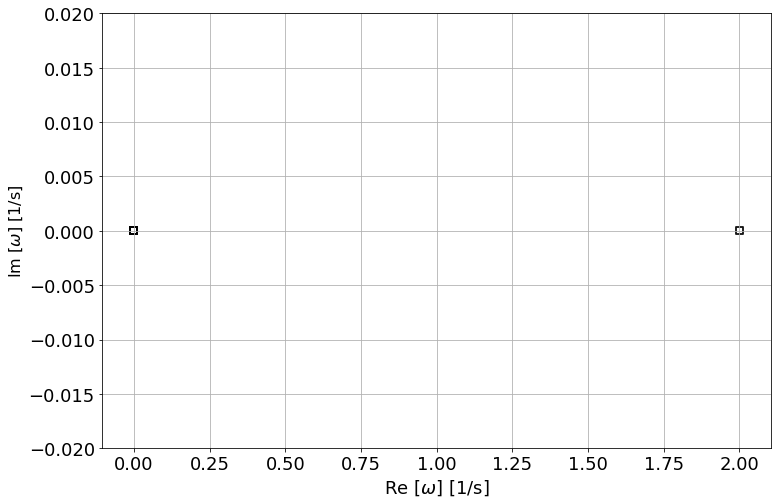

In [7]:
#####

# Plot eigenspectra 2
fig, ax = plt.subplots ()
area = 50

ax.scatter (realvals, imagvals, s = area, marker = listmarkers [0], color = listcolor [4], edgecolors = listcolor [0], linewidths = 1.5, alpha = 0.5)
# ax.set_xscale ('symlog',  linthreshx = 0.1)

# ax.xaxis.set_minor_locator(MultipleLocator(1e-15))
plt.rcParams ['figure.figsize'] = [12, 8]
# leg1 = ax.legend (loc = 'upper right', frameon = True, fontsize = 14);
plt.grid (True, which = "both")
plt.xlabel ('Re $[\omega]$ [1/s]', fontsize = 18)
plt.ylabel ('Im $[\omega]$ [1/s]', fontsize = 16)
        
matplotlib.rc ('xtick', labelsize = 18)     
matplotlib.rc ('ytick', labelsize = 18)

plt.ylim (- 0.02 , 0.02)
# plt.xlim (( - 5*realvals[localmaxreal[0][0]], 5*realvals[localmaxreal[0][0]])) #primeriro teste
# plt.xlim (( - 1e-12, 1e-12))

#####


(-1e-12, 1e-12)

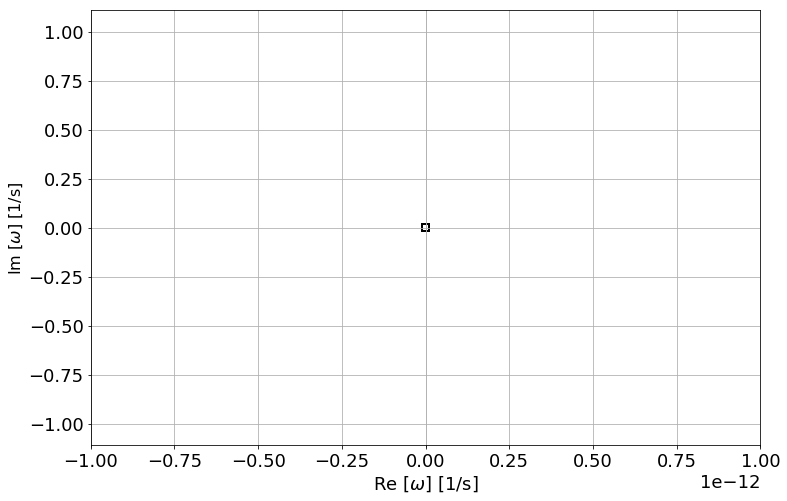

In [12]:

# Plot eigenspectra 3
fig, ax = plt.subplots ()
area = 50

ax.scatter (realvals, imagvals, s = area, marker = listmarkers [0], color = listcolor [4], edgecolors = listcolor [0], linewidths = 1.5, alpha = 0.5)
# ax.set_xscale ('symlog',  linthreshx = 1e-9)

ax.xaxis.set_minor_locator(MultipleLocator(1e-12))
plt.rcParams ['figure.figsize'] = [12, 8]
# leg1 = ax.legend (loc = 'upper right', frameon = True, fontsize = 14);
plt.grid (True, which = "both")
plt.xlabel ('Re $[\omega]$ [1/s]', fontsize = 18)
plt.ylabel ('Im $[\omega]$ [1/s]', fontsize = 16)
        
matplotlib.rc ('xtick', labelsize = 18)     
matplotlib.rc ('ytick', labelsize = 18)


# plt.ylim (( - 0.5 , 0.5))
# plt.xlim (( - 5*realvals[localmaxreal[0][0]], 5*realvals[localmaxreal[0][0]])) #primeriro teste
plt.xlim ( - 1e-12, 1e-12)

#####


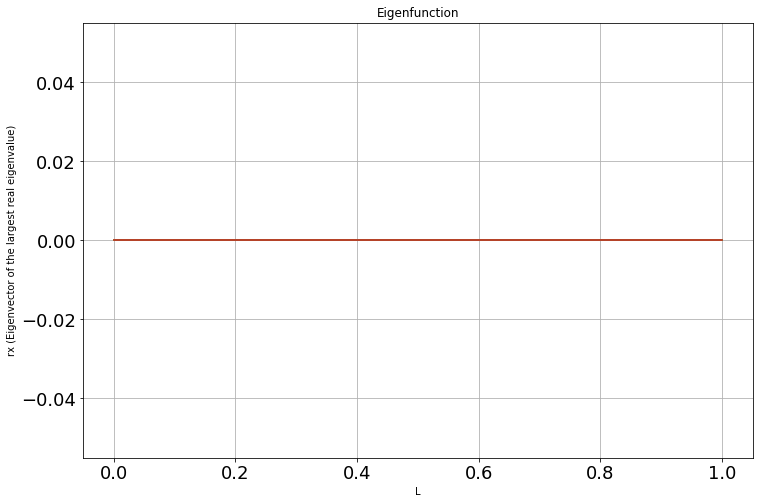

In [13]:
# Eigenvectors
# Plot real eigenvectors
ureal  = Function(V)
ureal.vector()[:] = eigenvector_real[0] #len(vecs)-1 
u1real, u2real, u3real, u4real= ureal.split()

# Plot eigenfunction
plt.figure (3, figsize = (12, 8))
plot(u1real, wireframe = True, title = 'Eigenfunction')
plt.grid (True, which = "both")
plt.xlabel("L")
plt.ylabel("rx (Eigenvector of the largest real eigenvalue)")

# Plot eigenfunction
plt.figure (3, figsize = (12, 8))
plot(u2real, wireframe = True, title = 'Eigenfunction')
plt.grid (True, which = "both")
plt.xlabel("L")
plt.ylabel("rx (Eigenvector of the largest real eigenvalue)")

# Plot eigenfunction
plt.figure (3, figsize = (12, 8))
plot(u3real, wireframe = True, title = 'Eigenfunction')
plt.grid (True, which = "both")
plt.xlabel("L")
plt.ylabel("rx (Eigenvector of the largest real eigenvalue)")

# Plot eigenfunction
plt.figure (3, figsize = (12, 8))
plot(u4real, wireframe = True, title = 'Eigenfunction')
plt.grid (True, which = "both")
plt.xlabel("L")
plt.ylabel("rx (Eigenvector of the largest real eigenvalue)")

# # Plot imaginary eigenvectors
# uimag = Function(V)
# uimag.vector()[:] = eigenvector_imag[0] #eigenfunction)
# u1imag, u2imag, u3imag, u4imag = uimag.split()
# 
# # Plot eigenfunction
# plt.figure (4, figsize = (12, 8))
# plot(u1imag, wireframe = True, title = 'Eigenfunction')
# plt.grid (True, which = "both")
# plt.xlabel("L")
# plt.ylabel("cx (Eigenvector of the largest imaginary eigenvalue)")

# plt.figure (4, figsize = (12, 8))
# plot(u2imag, wireframe = True, title = 'Eigenfunction')
# plt.grid (True, which = "both")
# plt.xlabel("L")
# plt.ylabel("cx (Eigenvector of the largest imaginary eigenvalue)")

# plt.figure (4, figsize = (12, 8))
# plot(u3imag, wireframe = True, title = 'Eigenfunction')
# plt.grid (True, which = "both")
# plt.xlabel("L")
# plt.ylabel("cx (Eigenvector of the largest imaginary eigenvalue)")

# plt.figure (4, figsize = (12, 8))
# plot(u4imag, wireframe = True, title = 'Eigenfunction')
# plt.grid (True, which = "both")
# plt.xlabel("L")
# plt.ylabel("cx (Eigenvector of the largest imaginary eigenvalue)")

plt.show()

# SAVE LARGEST REAL
File("slugging/eigenmodesu1_real.pvd") << u1real
File("slugging/eigenmodesu2_real.pvd") << u2real
File("slugging/eigenmodesu3_real.pvd") << u3real
File("slugging/eigenmodesu4_real.pvd") << u4real

# # SAVE LARGEST IMAGINARY
# File("slugging/eigenmodesu1_imag.pvd") << u1imag
# File("slugging/eigenmodesu2_imag.pvd") << u2imag
# File("slugging/eigenmodesu3_imag.pvd") << u3imag
# File("slugging/eigenmodesu4_imag.pvd") << u4imag


Condition number : 1.4606656143426954e+87


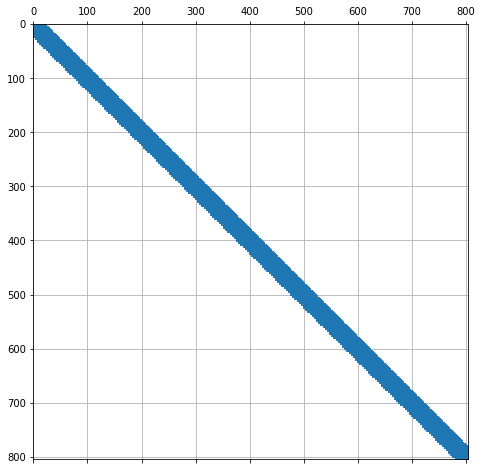

In [6]:
# 4/6
# Define weak form (semi distretised without artificial difussion)
F  = mass2 + mass1 + mom2 + mom1

# Auxiliary
dummy  = Constant (0)*v1*dx + Constant (0)*v2*dx + Constant (0)*v3*dx + Constant (0)*v4*dx

# Define Jacobian
dF = derivative (F, var, dvar)

########
# 2nd alternative to assembling
# Assemble stiffness form    
A  = PETScMatrix()
b  = PETScVector()

assemble_system(dF, dummy, bcs, A_tensor = A, b_tensor = b)

A_mat = as_backend_type(A).mat()

# Transform to numpy array
A_sparray = csr_matrix(A_mat.getValuesCSR()[::-1], shape = A_mat.size)

# Print array
# print("A_sparray             =", A_sparray)

# Plot array
plt.figure (3, figsize = (12, 8))
plt.spy(A_sparray)
plt.grid (True, which = "both")
# plt.rcParams ['figure.figsize'] = [12, 8]

plt.show


Acomplex_sparse = A_sparray.dot (1j)

Aeval           = A_sparray.toarray ()
Acomplex        = Aeval.dot (1j)

condnumber = LA.cond(Aeval)
print("Condition number :", condnumber)


In [7]:

eigensolver = SLEPcEigenSolver(A)
print("Computing eigenvalues. This can take a minute.")
# eigensolver.parameters["solver"] = "krylov-schur"
eigensolver.parameters["problem_type"] = "gen_hermitian"
# solver.parameters["spectrum"] = "target magnitude"
# eigensolver.parameters["spectral_transform"] = "shift-and-invert"
# eigensolver.parameters["spectral_shift"] = 5.5
# neigs = 12
eigensolver.solve ()    

# PARAMETERS
# https://fenicsproject.org/olddocs/dolfin/1.3.0/python/programmers-reference/cpp/la/SLEPcEigenSolver.html




# Computing the eigenvalues
real_eigenvalues = []
imag_eigenvalues = []
for ii in range(eigensolver.get_number_converged()):
    r, c, rx, cx = eigensolver.get_eigenpair(ii)
#     print ("i = ", ii)
#     print ("real      =", r)
#     print ("imaginary =", c)
    real_eigenvalues.append (r)
    imag_eigenvalues.append (c)
            
# Extract largest (first) eigenpair
r, c, rx, cx = eigensolver.get_eigenpair(0)
print("Largest eigenvalue real: ", r)
print("Largest eigenvalue imag: ", c)
print("Largest eigenvector real: ", rx)
print("Largest eigenvector imag: ", cx)



Computing eigenvalues. This can take a minute.
Largest eigenvalue real:  -1156.148677628691
Largest eigenvalue imag:  0.0
Largest eigenvector real:  <dolfin.cpp.la.PETScVector object at 0x7f96d5a42f10>
Largest eigenvector imag:  <dolfin.cpp.la.PETScVector object at 0x7f96d5a42e08>


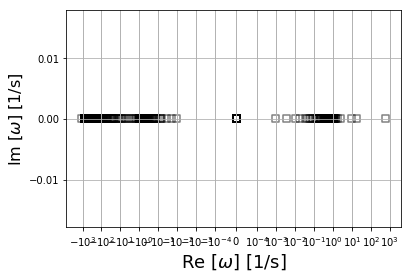

In [8]:

# Characteristics for plots
liststyles       = ["--", "-", "-.", "."]
listcolor        = ["k", "g", "b", "r", "none"]
listmarkers      = ["s", "o", "^", ">", "<", "p"]

# Plot eigenspectra 1
fig, ax = plt.subplots ()
area = 50

ax.scatter (real_eigenvalues, imag_eigenvalues, s = area, marker = listmarkers [0], color = listcolor [4], edgecolors = listcolor [0], linewidths = 1.5, alpha = 0.5)
ax.set_xscale ('symlog', linthreshx = 1e-4)

plt.rcParams ['figure.figsize'] = [12, 8]
# leg1 = ax.legend (loc = 'upper right', frameon = True, fontsize = 14);
plt.grid (True, which = "both")
plt.xlabel ('Re $[\omega]$ [1/s]', fontsize = 18)
plt.ylabel ('Im $[\omega]$ [1/s]', fontsize = 16)
        
matplotlib.rc ('xtick', labelsize = 18)     
matplotlib.rc ('ytick', labelsize = 18)

# plt.ylim (( - 0.002 , ))
# plt.xlim (( 2*vals.real[localminreal[0]], 2*vals.real[localmaxreal[0]]))
plt.show ()    


[-7.68494045e-05  1.58176803e-05  0.00000000e+00 -4.57729348e-04
  1.48889878e-04  6.59252840e-05  0.00000000e+00  4.32563253e-03
 -1.34040849e-04  4.89949798e-07  0.00000000e+00  3.52017091e-02
  1.39641673e-04 -3.71812479e-05  0.00000000e+00  1.17050781e-02
 -1.80771727e-04  6.80788816e-07  0.00000000e+00  2.20757061e-02
  1.77795066e-04  7.22413910e-05  0.00000000e+00  3.26097243e-02
 -1.21716790e-04  9.09907051e-06  0.00000000e+00 -2.55866987e-02
  1.30220409e-04  4.98365842e-05  0.00000000e+00 -1.59478259e-02
 -1.69761366e-04  5.20685659e-05  0.00000000e+00  5.04533316e-03
  1.46587909e-04 -1.34780858e-04  0.00000000e+00  2.36699617e-02
 -1.42833834e-04  6.35326243e-05  0.00000000e+00 -2.26310793e-02
  1.71145938e-04  5.92509144e-06  0.00000000e+00  5.02885517e-02
 -1.54987025e-04 -1.14936084e-05  0.00000000e+00 -6.06642799e-02
  1.31466036e-04  1.27209934e-04  0.00000000e+00  3.66756454e-02
 -1.33482672e-04 -3.56705478e-05  0.00000000e+00  2.38080132e-02
  1.51579031e-04 -3.40193

AttributeError: Vector length must match geometric dimension.

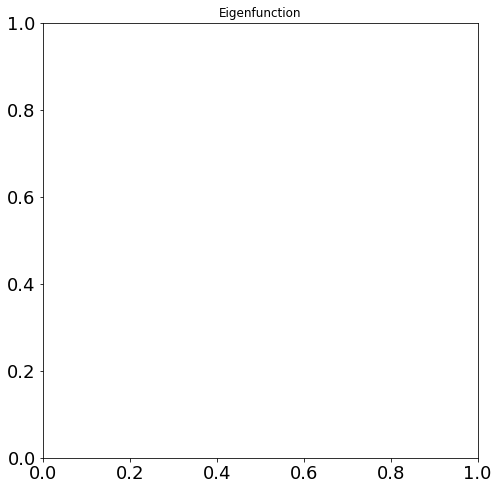

In [9]:
# Eigenvectors
# Plot real eigenvectors
rxarray = np.asarray(rx)
print(rxarray)
print(len(rxarray))
var  = Function(V)
var.vector()[:] = rxarray #len(vecs)-1 

# Plot eigenfunction
plot(var, wireframe = True, title='Eigenfunction')

plt.grid (True, which = "both")
plt.xlabel("L")
plt.ylabel("rx")

plt.show()

# # Plot eigenfunction
# plt.figure (3, figsize = (12, 8))
# plot(ureal, wireframe = True, title = 'Eigenfunction')
# plt.grid (True, which = "both")
# plt.xlabel("L")
# plt.ylabel("rx (Eigenvector of the largest real eigenvalue)")

# # Plot eigenfunction
# plt.figure (3, figsize = (12, 8))
# plot(u2real, wireframe = True, title = 'Eigenfunction')
# plt.grid (True, which = "both")
# plt.xlabel("L")
# plt.ylabel("rx (Eigenvector of the largest real eigenvalue)")

# # Plot eigenfunction
# plt.figure (3, figsize = (12, 8))
# plot(u3real, wireframe = True, title = 'Eigenfunction')
# plt.grid (True, which = "both")
# plt.xlabel("L")
# plt.ylabel("rx (Eigenvector of the largest real eigenvalue)")

# # Plot eigenfunction
# plt.figure (3, figsize = (12, 8))
# plot(u4real, wireframe = True, title = 'Eigenfunction')
# plt.grid (True, which = "both")
# plt.xlabel("L")
# plt.ylabel("rx (Eigenvector of the largest real eigenvalue)")

T         = 1.0
dt        = 0.023223077851641225
num_steps = 43


<function matplotlib.pyplot.show(*args, **kw)>

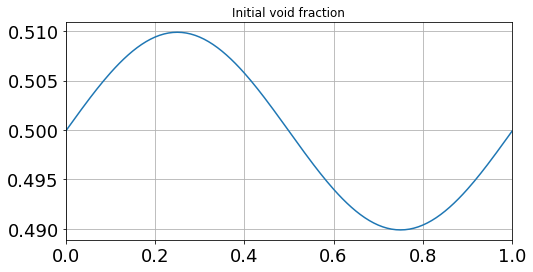

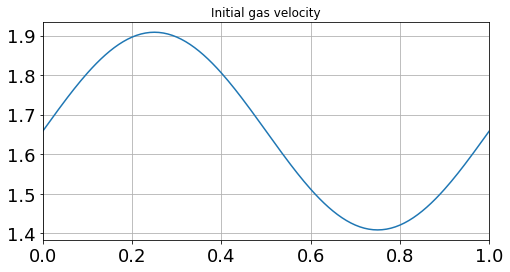

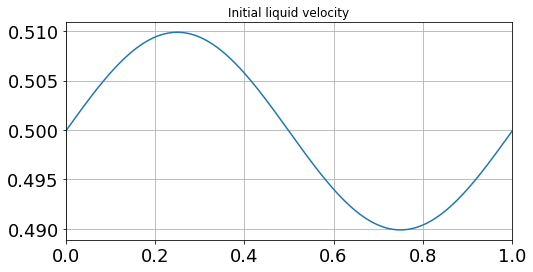

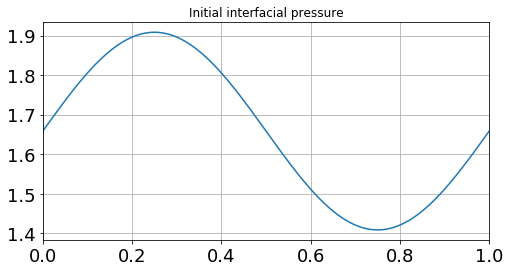

In [13]:

# Define time discretization properties
T         = 1.0                        # 1 cycle = 2*pi/k = 1 s (according to Hendrix)
CFL       = 0.9875                        # 0.7 Holmas, 0.978 Van Zwieten
dt        = CFL*deltax/(var2bc1)        # Van Zwieten & Smith /lambda_max Holmas (maximum modulus of the eigenvalues of the Jacobian of (4.1) at time step n)
                                        # Update u1
num_steps = int(round (T/dt))

# messages time discretization 
print('T         =', T)
print('dt        =', dt)
print('num_steps =', num_steps)

# Constants for initial conditions
k_wave     = 2*pi  #Hendrix
omega_wave = 8.484 #Hendrix

k_wave     = Constant(k_wave)
omega_wave = Constant(omega_wave)
t          = 0

# Define initial conditions
class InitialConditions (UserExpression):
    def eval (self, values, x):
        values[0] = var1bc1 + 0.01*sin(k_wave*x[0] - omega_wave*t) 
        values[1] = var2bc1 + 0.25*sin(k_wave*x[0] - omega_wave*t) 
        values[2] = var3bc1 + 7e-3*sin(k_wave*x[0] - omega_wave*t)
        values[3] = var4bc1 + 3.70*sin(k_wave*x[0] - omega_wave*t) 
    def value_shape (self):
        return (4,)

var_ic                         = InitialConditions (degree = p)
var_n                          = interpolate (var_ic, V) 
var1_n, var2_n, var3_n, var4_n = split (var_n)

# Plot initial conditions
plt.figure (1, figsize = (8, 4))
plt.grid (True, which = "both")
plt.xlim (xmin, xmax)
plot (var1_n, wireframe = True, title = "Initial void fraction")

plt.figure (2, figsize = (8, 4))
plt.grid (True, which = "both")
plt.xlim (xmin, xmax)
plot (var2_n, wireframe = True, title = "Initial gas velocity")

plt.figure (3, figsize = (8, 4))
plt.grid (True, which = "both")
plt.xlim (xmin, xmax)
plot (var1_n, wireframe = True, title = "Initial liquid velocity")

plt.figure (4, figsize = (8, 4))
plt.grid (True, which = "both")
plt.xlim (xmin, xmax)
plot (var2_n, wireframe = True, title = "Initial interfacial pressure")

plt.show


In [11]:
# 5/
# Numerical solution steady state (Not that posssble - transient phenomena)
# Define files
ff1 = File ("slugging/var1.pvd", "compressed")
ff2 = File ("slugging/var2.pvd", "compressed")
ff3 = File ("slugging/var3.pvd", "compressed")
ff4 = File ("slugging/var4.pvd", "compressed")
   
# solve stationary state
# Compute solution
problem = NonlinearVariationalProblem (F, var, bcs = bcs, J = dF, form_compiler_parameters = ffc_options)
solver  = NonlinearVariationalSolver (problem)
prm     = solver.parameters
    
info(prm, True)
    
prm ['nonlinear_solver'] = 'newton'
prm ['print_matrix']     = False #True
prm ['print_rhs']        = False #True
prm ['symmetric']        = False #True
    
prm ['newton_solver']['absolute_tolerance']      = 1e-1 #1E-8
prm ['newton_solver']['convergence_criterion']   = 'residual' #'residual' 'incremental'
# prm ['newton_solver']['error_on_nonconvergence'] = True
prm ['newton_solver']['linear_solver']           = 'umfpack' # 'bicgstab' 'cg' 'gmres' 'minres' 'petsc' 'richardson' 'superlu_dist' 'tfqmr' 'umfpack'
prm ['newton_solver']['maximum_iterations']      = 10000
#     prm ['newton_solver']['preconditioner']          = 'ilu' # 'ilu' 'icc' 'petsc_amg' 'sor'
prm ['newton_solver']['relative_tolerance']      = 1e-1
prm ['newton_solver']['relaxation_parameter']    = 1.0
prm ['newton_solver']['report']                  = True

# prm ['newton_solver']['krylov_solver']['absolute_tolerance']       = 1e-3 #1E-9
# #     prm ['newton_solver']['krylov_solver']['error_on_nonconvergence']  = True
# prm ['newton_solver']['krylov_solver']['maximum_iterations']       = 10000 # 500000
prm ['newton_solver']['krylov_solver']["monitor_convergence"]      = True
prm ['newton_solver']['krylov_solver']["nonzero_initial_guess"]    = True #False
# prm ['newton_solver']['krylov_solver']['relative_tolerance']       = 1e-3
prm ['newton_solver']['krylov_solver']['report']                   = True
    
prm ['newton_solver']['lu_solver']['report']    = True
prm ['newton_solver']['lu_solver']['symmetric'] = False
prm ['newton_solver']['lu_solver']['verbose']   = True

PROGRESS = 1
set_log_level (PROGRESS)

solver.solve ()
    
(var1, var2, var3, var4) = var.split (deepcopy = True)
    
# Plot solution
plt.figure (5, figsize = (8, 4))
    #plt.clf()
plot (var1, wireframe = True, title = "Void fraction")
    
plt.figure (6, figsize = (8, 4))
    #plt.clf()
plot (var2, wireframe = True, title = "Gas velocity")
    
plt.figure (7, figsize = (8, 4))
    #plt.clf()
plot (var2, wireframe = True, title = "Liquid velocity")
    
plt.figure (8, figsize = (8, 4))
    #plt.clf()
plot (var2, wireframe = True, title = "Interfacial pressure")
 
# Save solution
ff1 << var1
ff2 << var2
ff1 << var3
ff2 << var4

# Show time of the program's execution
start_time  = time.time ()
if __name__ == '__main__':
    print("Time of the program's execution: %s seconds " % (time.time () - start_time))
    
# solvers and preconditioners
# https://github.com/hplgit/fenics-tutorial/issues/33


Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


RuntimeError: 

*** -------------------------------------------------------------------------
*** DOLFIN encountered an error. If you are not able to resolve this issue
*** using the information listed below, you can ask for help at
***
***     fenics-support@googlegroups.com
***
*** Remember to include the error message listed below and, if possible,
*** include a *minimal* running example to reproduce the error.
***
*** -------------------------------------------------------------------------
*** Error:   Unable to solve nonlinear system with NewtonSolver.
*** Reason:  Newton solver did not converge because maximum number of iterations reached.
*** Where:   This error was encountered inside NewtonSolver.cpp.
*** Process: 0
*** 
*** DOLFIN version: 2019.1.0
*** Git changeset:  unknown
*** -------------------------------------------------------------------------


In [ ]:
# 6/
# Numerical solution transient state
# Define weak form (discretised system)
F = ((var1 - var2_n) / k)*v1*dx + (A11 (var1, var2)*v1*Dx(var1,0))*dx + A12 (var1, var2)*(v1*Dx(var2,0))*dx + (inner(E11*grad(var1), grad(v1)))*dx + force*v1*dx\
+ ((var2 - var2_n) / k)*v2*dx + A21 (var1, var2)*v2*Dx(var1,0)*dx + (A22 (var1, var2)*v2*Dx(var2,0))*dx + inner(E22*grad(var2), grad(v2))*dx - D2 (var1, var2)*v2*dx + force*v2*dx

# Define Jacobian
dF = derivative (F, var, dvar)

# Define files
ff1 = File ("slugging/var1.pvd", "compressed")
ff2 = File ("slugging/var2.pvd", "compressed")
ff3 = File ("slugging/var3.pvd", "compressed")
ff4 = File ("slugging/var4.pvd", "compressed")

# Iterative process
t = 0
for n in range (num_steps):

    # Update current time (CHECK PERIODIC BOUNDARY CONDITIONS)
    t += dt
    #u_D.t = t
    
    # Print progress
    clear_output ()
    print("Iteration :", t/dt, "of", num_steps)
    print("Time      :", t, "s")
    
    # Compute solution
    problem = NonlinearVariationalProblem (F, var, bcs = bcs, J = dF, 'ffc_options')
    solver  = NonlinearVariationalSolver (problem)
    prm     = solver.parameters
    
    info(prm, True)
    
    prm ['nonlinear_solver'] = 'newton'
    prm ['print_matrix']     = False #True
    prm ['print_rhs']        = False #True
    prm ['symmetric']        = False #True
    
    prm ['newton_solver']['absolute_tolerance']      = 1e-8 #1E-8
    prm ['newton_solver']['convergence_criterion']   = 'residual' #'residual' 'incremental'
    prm ['newton_solver']['error_on_nonconvergence'] = True
    prm ['newton_solver']['linear_solver']           = 'bicgstab' # 'bicgstab' 'cg' 'gmres' 'minres' 'petsc' 'richardson' 'superlu_dist' 'tfqmr' 'umfpack'
    prm ['newton_solver']['maximum_iterations']      = 1000
    prm ['newton_solver']['preconditioner']          = 'amg' # 'ilu' 'icc' 'petsc_amg' 'sor'
    prm ['newton_solver']['relative_tolerance']      = 1e-8
    prm ['newton_solver']['relaxation_parameter']    = 1.0
    prm ['newton_solver']['report']                  = True

    prm ['newton_solver']['krylov_solver']['absolute_tolerance']       = 1e-8 #1E-9
#     prm ['newton_solver']['krylov_solver']['error_on_nonconvergence']  = True
    prm ['newton_solver']['krylov_solver']['maximum_iterations']       = 50000 # 500000
    prm ['newton_solver']['krylov_solver']["monitor_convergence"]      = False
    prm ['newton_solver']['krylov_solver']["nonzero_initial_guess"]    = True #False
    prm ['newton_solver']['krylov_solver']['relative_tolerance']       = 1e-8
    prm ['newton_solver']['krylov_solver']['report']                   = False
    
    prm ['newton_solver']['lu_solver']['report']    = True
    prm ['newton_solver']['lu_solver']['symmetric'] = False
    prm ['newton_solver']['lu_solver']['verbose']   = True

    PROGRESS = 1
    set_log_level (PROGRESS)
    
    solver.solve ()
    
    (var1, var2) = var.split (deepcopy = True)
    
    # Plot solution
    plt.figure (5, figsize = (8, 4))
        #plt.clf()
    plot (var1, wireframe = True, title = "Void fraction")

    plt.figure (6, figsize = (8, 4))
        #plt.clf()
    plot (var2, wireframe = True, title = "Gas velocity")

    plt.figure (7, figsize = (8, 4))
        #plt.clf()
    plot (var2, wireframe = True, title = "Liquid velocity")

    plt.figure (8, figsize = (8, 4))
        #plt.clf()
    plot (var2, wireframe = True, title = "Interfacial pressure")

    # Update previous solution
    var_n.assign (var)
    
    # Save solution
    ff1 << var1
    ff2 << var2
    ff1 << var3
    ff2 << var4

# Hold plot
plt.show ()

# Show time of the program's execution
start_time  = time.time ()
if __name__ == '__main__':
    print("Time of the program's execution: %s seconds " % (time.time () - start_time))
    

In [ ]:
# B) Steady state stratified flow 
# Continue after definition of functions for weak form of transient TFM

In [26]:
# Define functions used in weak form

mass2 = ( - 0*Dx (conv_mass2 (var1, var2, var3, var4),0)*v1 + \
         0*(inner (var4*E11/pow(c2,2)*grad (var1), grad (v1))) )*dx

mass1 = ( - 0*Dx (conv_mass1 (var1, var2, var3, var4),0)*v2 + \
         0*(inner (rho1*E11*grad (1-var1), grad (v1))) )*dx

mom2  = ( - 0*Dx (conv_mom2 (var1, var2, var3, var4),0)*v3 - (var1)*Dx (var4,0)*v3 + \
         0*Dc2 (var1, var2, var3, var4)*Dx (var1,0)*v3   - F2 (var1,var2,var3,var4)*v3 - \
         F21 (var1,var2,var3,var4)*v3 - var4*var1*g*sin (beta1)/pow (abs (c2),2)*v3 - \
         force*v3 + 0*(inner (var1*E22*grad (var2), grad (v3))) )*dx

mom1  = ( - 0*Dx (conv_mom1 (var1, var2, var3, var4),0)*v4 - (1 - var1)*Dx (var4,0)*v4 - \
         0*Dc1 (var1, var2, var3, var4)*Dx (1-var1,0)*v4 - F1 (var1,var2,var3,var4)*v4 - \
         F12 (var1,var2,var3,var4)*v4 - rho1*(1 - var1)*g*sin (beta1)*v4 - force*v4 +\
         0*(inner ((1-var1)*E22*grad (var3), grad (v4))))*dx


This integral is missing an integration domain.


UFLException: This integral is missing an integration domain.

In [6]:
# Define weak form (semi distretised without artificial difussion)
F  = mass2 + mass1 + mom2 + mom1

# Auxiliary
L  = Constant (0)*v1*dx + Constant (0)*v2*dx + Constant (0)*v3*dx + Constant (0)*v4*dx

# Define Jacobian
dF = derivative (F, var, dvar)


In [25]:
# Define files
ff1 = File ("slugging_steady/var1.pvd", "compressed")
ff2 = File ("slugging_steady/var2.pvd", "compressed")
ff3 = File ("slugging_steady/var3.pvd", "compressed")
ff4 = File ("slugging_steady/var4.pvd", "compressed")


# solve stationary state
# Compute solution
problem = NonlinearVariationalProblem (F, var, bcs = bcs, J = dF, form_compiler_parameters = ffc_options)
solver  = NonlinearVariationalSolver (problem)
prm     = solver.parameters
    
info(prm, True)
    
prm ['nonlinear_solver'] = 'newton'
prm ['print_matrix']     = False #True
prm ['print_rhs']        = False #True
prm ['symmetric']        = True #True
    
prm ['newton_solver']['absolute_tolerance']      = 1e-4 #1E-8
prm ['newton_solver']['convergence_criterion']   = 'residual' #'residual' 'incremental'
# prm ['newton_solver']['error_on_nonconvergence'] = True
prm ['newton_solver']['linear_solver']           = 'cg' # 'bicgstab' 'cg' 'gmres' 'minres' 'petsc' 'richardson' 'superlu_dist' 'tfqmr' 'umfpack'
# prm ['newton_solver']['maximum_iterations']      = 10000
prm ['newton_solver']['preconditioner']          = 'ilu' # 'ilu' 'icc' 'petsc_amg' 'sor'
prm ['newton_solver']['relative_tolerance']      = 1e-3
prm ['newton_solver']['relaxation_parameter']    = 1.0
prm ['newton_solver']['report']                  = True

prm ['newton_solver']['krylov_solver']['absolute_tolerance']       = 1e-3 #1E-9
#     prm ['newton_solver']['krylov_solver']['error_on_nonconvergence']  = True
prm ['newton_solver']['krylov_solver']['maximum_iterations']       = 1000000 # 500000
prm ['newton_solver']['krylov_solver']["monitor_convergence"]      = True
prm ['newton_solver']['krylov_solver']["nonzero_initial_guess"]    = True #False
prm ['newton_solver']['krylov_solver']['relative_tolerance']       = 1e-3
prm ['newton_solver']['krylov_solver']['report']                   = True
    
prm ['newton_solver']['lu_solver']['report']    = True
prm ['newton_solver']['lu_solver']['symmetric'] = False
prm ['newton_solver']['lu_solver']['verbose']   = True

PROGRESS = 1
set_log_level (PROGRESS)

solver.solve ()
    
(var1, var2, var3, var4) = var.split (deepcopy = True)
    
# Plot solution
plt.figure (5, figsize = (8, 4))
    #plt.clf()
plot (var1, wireframe = True, title = "Void fraction")
    
plt.figure (6, figsize = (8, 4))
    #plt.clf()
plot (var2, wireframe = True, title = "Gas velocity")
    
plt.figure (7, figsize = (8, 4))
    #plt.clf()
plot (var2, wireframe = True, title = "Liquid velocity")
    
plt.figure (8, figsize = (8, 4))
    #plt.clf()
plot (var2, wireframe = True, title = "Interfacial pressure")
 
# Save solution
ff1 << var1
ff2 << var2
ff1 << var3
ff2 << var4

# Show time of the program's execution
start_time  = time.time ()
if __name__ == '__main__':
    print("Time of the program's execution: %s seconds " % (time.time () - start_time))
    
# solvers and preconditioners
# https://github.com/hplgit/fenics-tutorial/issues/33


RuntimeError: 

*** -------------------------------------------------------------------------
*** DOLFIN encountered an error. If you are not able to resolve this issue
*** using the information listed below, you can ask for help at
***
***     fenics-support@googlegroups.com
***
*** Remember to include the error message listed below and, if possible,
*** include a *minimal* running example to reproduce the error.
***
*** -------------------------------------------------------------------------
*** Error:   Unable to solve linear system using PETSc Krylov solver.
*** Reason:  Solution failed to converge in 0 iterations (PETSc reason DIVERGED_NANORINF, residual norm ||r|| = -nan).
*** Where:   This error was encountered inside PETScKrylovSolver.cpp.
*** Process: 0
*** 
*** DOLFIN version: 2019.1.0
*** Git changeset:  unknown
*** -------------------------------------------------------------------------


In [ ]:
# PERIODIC BOUNDARY CONDITIONS

l1 min, max  0.09868792685377065 399.90131207314636
l2 min, max  1.0 119911.22467109752
eig min, max  9.869604401089358 96731.9927350768


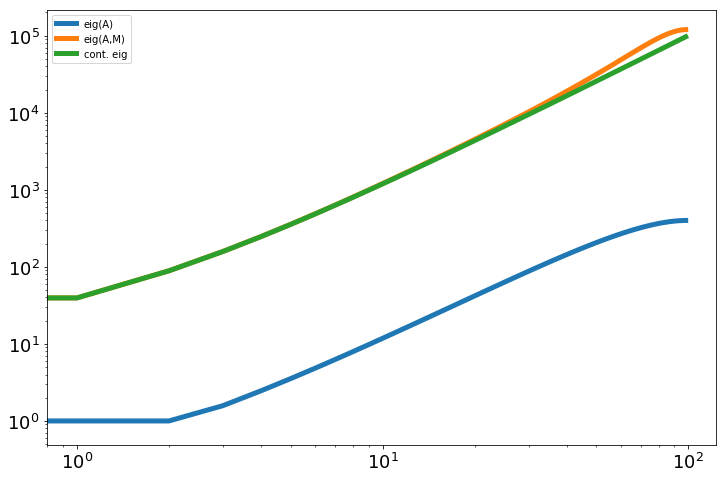

l1 min, max  0.009869596284014888 3999.9901304037157
l2 min, max  1.0 11999911.174071778
eig min, max  9.869604401089358 9849875.06189158


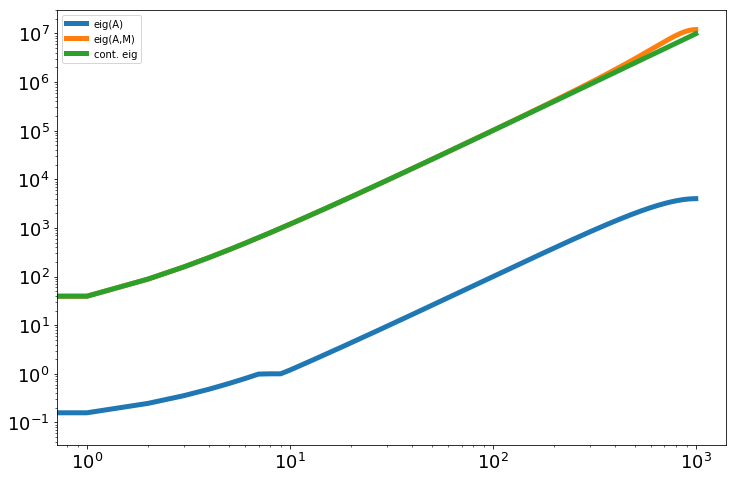

In [17]:
from dolfin import *
import numpy
from scipy import linalg, matrix

def boundary(x, on_boundary): return on_boundary

for N in [100, 1000]:
    mesh = UnitIntervalMesh(N)
    V = FunctionSpace(mesh, "Lagrange", 1)
    u = TrialFunction(V)
    v = TestFunction(V)
    
    bc = DirichletBC(V, Constant(0), boundary)
    A, _ = assemble_system(inner(grad(u), grad(v))*dx, Constant(0)*v*dx, bc)
    M, _ = assemble_system(u*v*dx, Constant(0)*v*dx, bc)
    
    AA = matrix(A.array())
    MM = matrix(M.array())
    
    k = numpy.arange(1, N, 1)
    eig = pi**2*k**2
    
    l1, v = linalg.eigh(AA)
    l2, v = linalg.eigh(AA, MM)
    
    print("l1 min, max ", min(l1), max(l1))
    print("l2 min, max ", min(l2), max(l2))
    print("eig min, max ", min(eig), max(eig))
        
    import pylab
    pylab.loglog(l1[2:], linewidth=5) # exclude the two smallest (they correspond to Dirichlet cond))
    pylab.loglog(l2[2:], linewidth=5) # exclude the two smallest again
    pylab.loglog(eig, linewidth=5)
    pylab.legend(["eig(A)", "eig(A,M)", "continous. eig"], loc="upper left")
    pylab.show()

In [24]:
from dolfin import *
from numpy import linalg

for D in [1, 2]:
    for N in [4, 8, 16, 32]:
        if D == 1: mesh = UnitIntervalMesh(N)
        elif D == 2: mesh = UnitSquareMesh(N, N)

        V = FunctionSpace(mesh, "Lagrange", 1)
        u = TrialFunction(V)
        v = TestFunction(V)

        a = u*v*dx + inner(grad(u), grad(v))*dx
        A = assemble(a)
        e = linalg.eigvals(A.array())
        e.sort()
        c = e[-1] / e[0]

        print("D=%d, N=%3d, min eigenvalue=%5.3f, max eigenvalue=%5.3f, cond. number=%5.3f " \
              % (D, N, e[0], e[-1], c))

D=1, N=  4, min eigenvalue=0.199, max eigenvalue=14.562, cond. number=73.041 
D=1, N=  8, min eigenvalue=0.111, max eigenvalue=31.078, cond. number=279.992 
D=1, N= 16, min eigenvalue=0.059, max eigenvalue=63.476, cond. number=1079.408 
D=1, N= 32, min eigenvalue=0.030, max eigenvalue=127.721, cond. number=4215.105 
D=2, N=  4, min eigenvalue=0.040, max eigenvalue=7.090, cond. number=178.444 
D=2, N=  8, min eigenvalue=0.012, max eigenvalue=7.735, cond. number=627.873 
D=2, N= 16, min eigenvalue=0.003, max eigenvalue=7.929, cond. number=2292.822 
D=2, N= 32, min eigenvalue=0.001, max eigenvalue=7.982, cond. number=8693.355 


In [ ]:
level set
http://www.karlin.mff.cuni.cz/~hron/fenics-tutorial/multiphase/doc.html

    MUMPS E SOLVERS
    https://fenicsproject.discourse.group/t/using-the-mumps-solver-when-calling-solve/1198/3

In [ ]:
ffc_options = {"quadrature_degree": 4, "optimize": True, "eliminate_zeros": False}
problem=NonlinearVariationalProblem(F,w,bcs,J,ffc_options)
solver=NonlinearVariationalSolver(problem)

prm = solver.parameters
#info(prm, True)
prm['nonlinear_solver'] = 'newton'
prm['newton_solver']['linear_solver'] = 'umfpack'
prm['newton_solver']['lu_solver']['report'] = False
prm['newton_solver']['lu_solver']['same_nonzero_pattern']=True
prm['newton_solver']['absolute_tolerance'] = 1E-10
prm['newton_solver']['relative_tolerance'] = 1E-10
prm['newton_solver']['maximum_iterations'] = 20
prm['newton_solver']['report'] = True
#prm['newton_solver']['error_on_nonconvergence'] = False
